# Relativistic Boris method

\begin{align}
\textbf{u}=\gamma\textbf{v} \\
q^\prime=\Delta t\frac{q}{2m} \\
\textbf{u}^-=\textbf{u}^{n-1/2}+q^\prime\textbf{E}(\textbf{x}^n) \\
(\gamma^n)^2=1+(u^-/c)^2 \\
\textbf{h} = \frac{q^\prime}{\gamma^n}\textbf{B}(\textbf{x}^n) \\
\textbf{s}=2\textbf{h}/(1+h^2) \\
\textbf{u}^+=\textbf{u}^-+(\textbf{u}^-+(\textbf{u}^-\times\textbf{h}))\times\textbf{s} \\
\textbf{u}^{n+1/2}=\textbf{u}^++q^\prime\textbf{E}(\textbf{x}^n) \\ 
\textbf{x}^{n+1}=\textbf{x}^n+\textbf{v}^{n+1/2}\Delta t=\textbf{x}^n+\frac{\textbf{u}^{n+1/2}\Delta t}{\gamma^{n+1/2}}
\end{align}

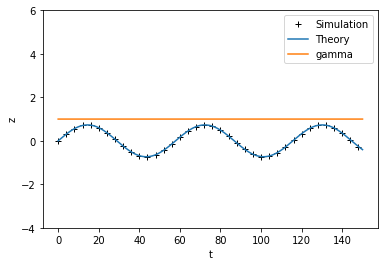

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from copy import deepcopy


# ... parameters
q = -1.0
m = 1.0
c = 1
B0 = 1
wce = q*B0/m
xi = 0.862
dt = 0.02
Nt = 7500
T = Nt*dt
E0 = np.zeros((2,3))
# ...


def gamma(v):
    return 1/np.sqrt(1 - np.linalg.norm(v)**2/c**2)

def gammau(u):
    return np.sqrt(1 + np.linalg.norm(u,axis = 1)**2/c**2)


# ... create two test particles
tn = np.linspace(0,T,Nt+1)

particles3d3v = np.zeros((Nt+1,2,6))
particles1d3v = np.zeros((Nt+1,2,4))
# ...


# ... set initial values
vtest1 = np.array([0.117,0,0.0795])
vtest2 = np.array([0.167,0,0.0595])

utest1 = gamma(vtest1)*vtest1
utest2 = gamma(vtest2)*vtest2

xtest1 = np.array([0,np.abs(utest1[0]*m/(q*B0)),0])
xtest2 = np.array([0,np.abs(utest2[0]*m/(q*B0)),0])

particles3d3v[0,0,3:6] = utest1
particles3d3v[0,1,3:6] = utest2

particles3d3v[0,0,0:3] = xtest1
particles3d3v[0,1,0:3] = xtest2

particles1d3v[0,0,1:4] = utest1
particles1d3v[0,1,1:4] = utest2

particles1d3v[0,0,0] = -0.00
particles1d3v[0,1,0] = -1.62
# ...



def pushBorisRelativistic3d3v(particles,q,m,dt,B,E):
    
    qprime = dt*q/(2*m)
    uminus = particles[:,3:6] + qprime*E
    
    h = qprime*B/np.sqrt(1 + np.linalg.norm(uminus,axis = 1)**2/c**2)[:,None]
    s = 2*h/(1 + np.linalg.norm(h,axis = 1)**2)[:,None]
    
    uplus = uminus + np.cross(uminus + np.cross(uminus,h),s)
    unew = uplus + qprime*E
    xnew = particles[:,0:3] + dt*unew/np.sqrt(1 + np.linalg.norm(unew,axis = 1)**2/c**2)[:,None]
       
    return xnew,unew



def pushBorisRelativistic1d3v(particles,q,m,dt,B,E):
    
    qprime = dt*q/(2*m)
    uminus = particles[:,1:4] + qprime*E
    
    h = qprime*B/np.sqrt(1 + np.linalg.norm(uminus,axis = 1)**2/c**2)[:,None]
    s = 2*h/(1 + np.linalg.norm(h,axis = 1)**2)[:,None]
    
    uplus = uminus + np.cross(uminus + np.cross(uminus,h),s)
    unew = uplus + qprime*E
    znew = particles[:,0] + dt*unew[:,2]/np.sqrt(1 + np.linalg.norm(unew,axis = 1)**2/c**2)
       
    return znew,unew




def Bfield3d3v(x,B0,xi):
    
    Bx = -x[:,0]*B0*xi*x[:,2]
    By = -x[:,1]*B0*xi*x[:,2]
    Bz = B0*(1 + xi*x[:,2]**2)
    
    return np.transpose(np.array([Bx,By,Bz]))



def Bfield1d3v(u,z,B0,xi):
    
    Bz = B0*(1 + xi*z**2)
    Omega = q*Bz/m
    rho = -np.cross(u,np.array([0,0,1]))/Omega[:,None]
    
    
    Bx = -rho[:,0]*B0*xi*z
    By = -rho[:,1]*B0*xi*z
    
    
    return np.transpose(np.array([Bx,By,Bz]))




particles3d3v[0,:,3:6] = pushBorisRelativistic3d3v(particles3d3v[0],q,m,-dt/2,Bfield3d3v(particles3d3v[0,:,0:3],B0,xi),E0)[1]
particles1d3v[0,:,1:4] = pushBorisRelativistic1d3v(particles1d3v[0],q,m,-dt/2,Bfield1d3v(particles1d3v[0,:,1:4],particles1d3v[0,:,0],B0,xi),E0)[1]




# ... time integration
for n in range(0,Nt):
    #particles3d3v[n+1,:,0:3],particles3d3v[n+1,:,3:6] = pushBorisRelativistic3d3v(particles3d3v[n],q,m,dt,Bfield3d3v(particles3d3v[n,:,0:3],B0,xi),E0)
    particles1d3v[n+1,:,0],particles1d3v[n+1,:,1:4] = pushBorisRelativistic1d3v(particles1d3v[n],q,m,dt,Bfield1d3v(particles1d3v[n,:,1:4],particles1d3v[n,:,0],B0,xi),E0)
# ...



# ... analytical solution
def zana(t):
    
    z0 = particles1d3v[0,0,0]
    Bz0 = B0*(1 + xi*z0**2)
    Omega = q*Bz0/m
    rho = -np.cross(utest1,np.array([0,0,1]))/Omega
    
    omegab = vtest1[0]*np.sqrt(xi/np.sqrt((1 + xi*z0**2)**2 + (rho[0]*B0*xi*z0)**2 + (rho[1]*B0*xi*z0)**2))
    
    return particles1d3v[0,0,0]*np.cos(omegab*t) + vtest1[2]/omegab*np.sin(omegab*t)
# ...



plt.plot(tn[::200],particles1d3v[::200,0,0],'k+',label = 'Simulation')
plt.plot(tn,zana(tn),label = 'Theory')
plt.xlabel('t')
plt.ylabel('z')
plt.ylim((-4,6))



# ... check energy conservation
gammas = gammau(particles1d3v[:,0,1:4])
gammamax = np.max(gammas)
gammamin = np.min(gammas)

diff = (gammamax - gammamin)/gammamin
plt.plot(tn,gammas/gammas[0],label = 'gamma')
# ...

plt.legend()